In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm import *
import torch
import random
from pathlib import Path
from config import *
from utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_forecast_sl_30_run_1


In [3]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_forecast_sl_30_run_1


In [4]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/roberto/Documents/backup_rob/repo/esa_fdir/time_series_anomaly_detection/model_results/esa_exploration/lstm/4_wheel_system_forecast_sl_30_run_1/summary.csv


In [5]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,29,28,"trainLSTM_07553_00017_17_batch_size=500,embedd...",75792,0.078541,0.090437
1,27,19,"trainLSTM_07553_00021_21_batch_size=500,embedd...",75792,0.081643,0.090580
2,28,10,"trainLSTM_07553_00002_2_batch_size=500,embeddi...",75792,0.081641,0.090580
3,26,29,"trainLSTM_07553_00025_25_batch_size=100,embedd...",75792,0.076208,0.090915
4,25,5,"trainLSTM_07553_00026_26_batch_size=100,embedd...",109072,0.077883,0.090924
5,24,27,"trainLSTM_07553_00003_3_batch_size=500,embeddi...",109072,0.084764,0.091051
6,23,7,"trainLSTM_07553_00010_10_batch_size=100,embedd...",109072,0.071042,0.091195
7,22,23,"trainLSTM_07553_00020_20_batch_size=500,embedd...",84240,0.078580,0.091328
8,21,0,"trainLSTM_07553_00027_27_batch_size=500,embedd...",117520,0.081396,0.091393
9,20,22,"trainLSTM_07553_00004_4_batch_size=100,embeddi...",290832,0.058300,0.091543


In [6]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 500, 'embedding_dim': 32, 'epochs': 200, 'lr': 0.0006, 'lr_patience': 5, 'n_layers_cell_1': 2, 'n_layers_cell_2': 2, 'seq_in_length': 30}


In [7]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [8]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [9]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [10]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 300
random shift 85247


In [11]:
num_batch = 2
inject_anomalies = False
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
if inject_anomalies:
    x, shift = unrolling_batches_with_anomalies(num_batch=num_batch, test_iter=test_iter, sigma=3,
                             sequence_length=params_conf['sequence_length'], cols=cfg.dataset.columns
                                                , shift = None)
else:
    x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=params_conf['sequence_length'], cols=cfg.dataset.columns
                                 , shift = None)

time horizon 60
random shift 105240


In [12]:
model = LSTM(seq_in=params_conf['sequence_length'], seq_out= params_conf['out_window']
              , n_features=params_conf['n_features'],
            output_size=params_conf["output_size"], embedding_dim=params_conf['embedding_dim'],
            n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Encoder(
  (LSTMenc): LSTM(16, 64, num_layers=2, batch_first=True)
  (LSTM1): LSTM(64, 32, num_layers=2, batch_first=True)
  (out): Linear(in_features=32, out_features=16, bias=True)
)
number of params 75792


In [13]:
yo = model(x.to(device))

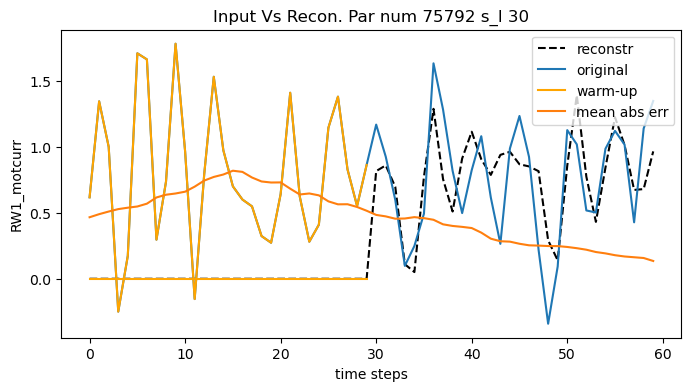

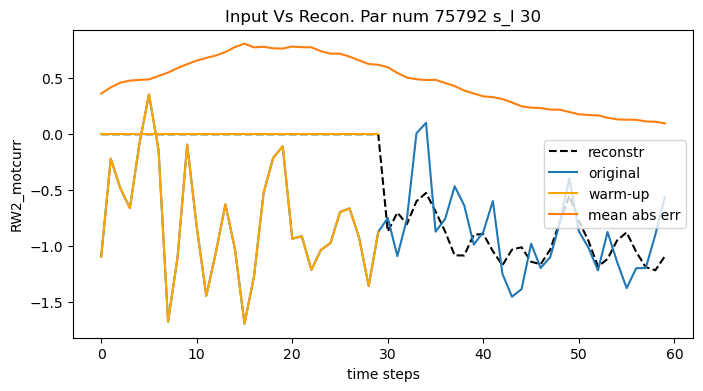

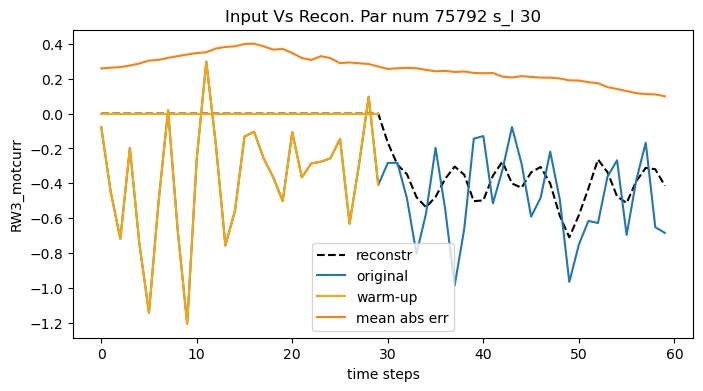

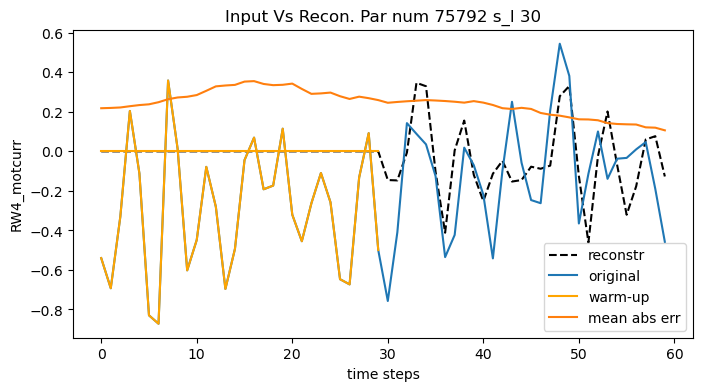

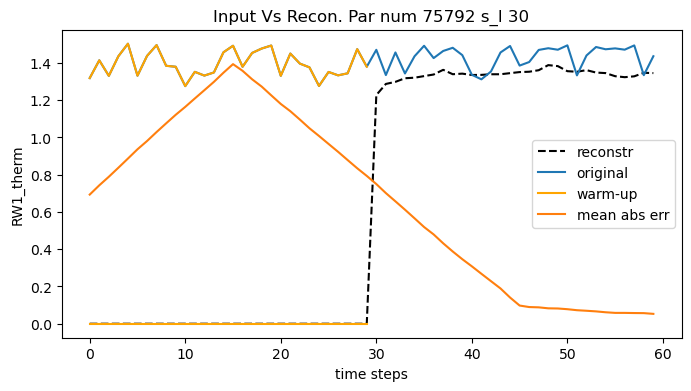

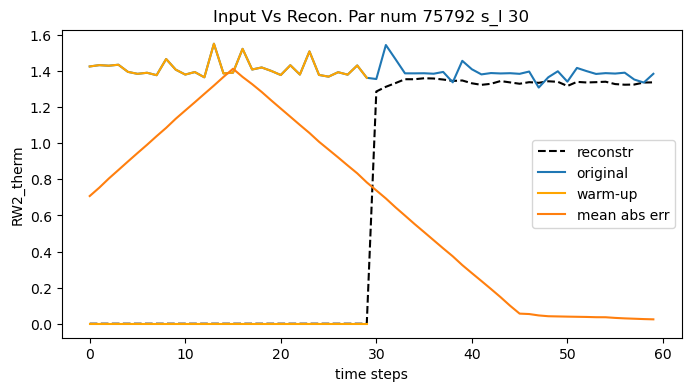

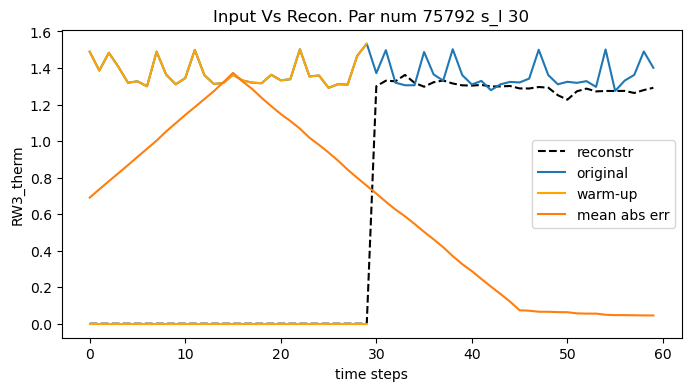

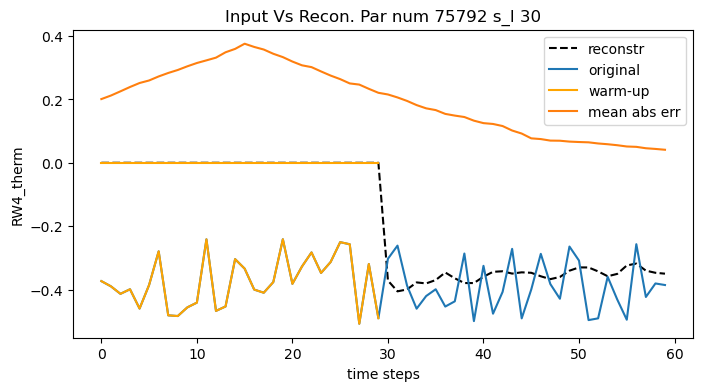

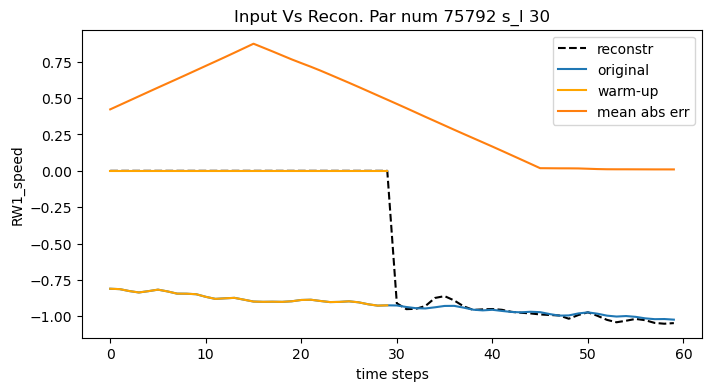

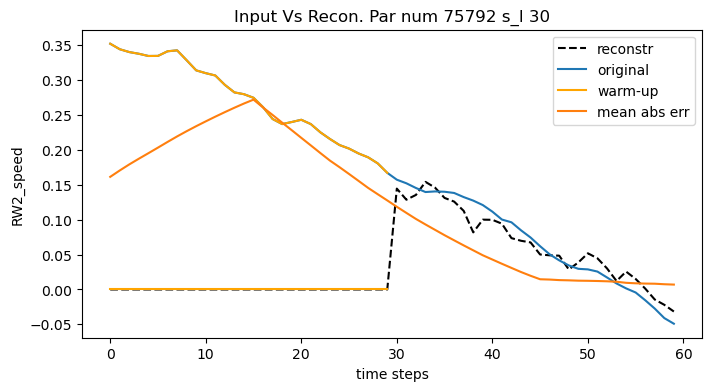

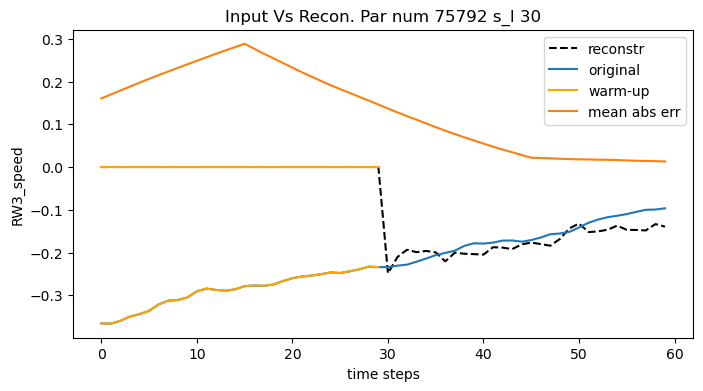

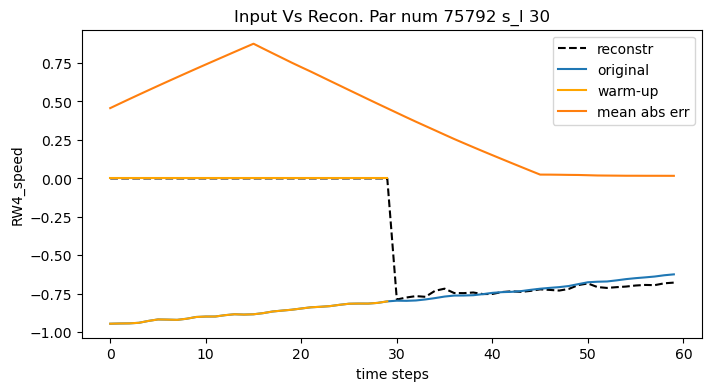

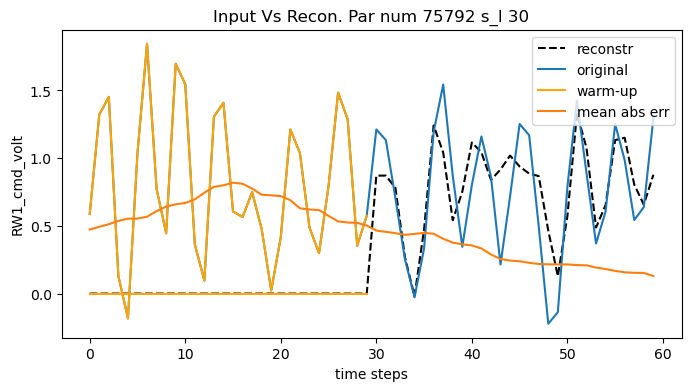

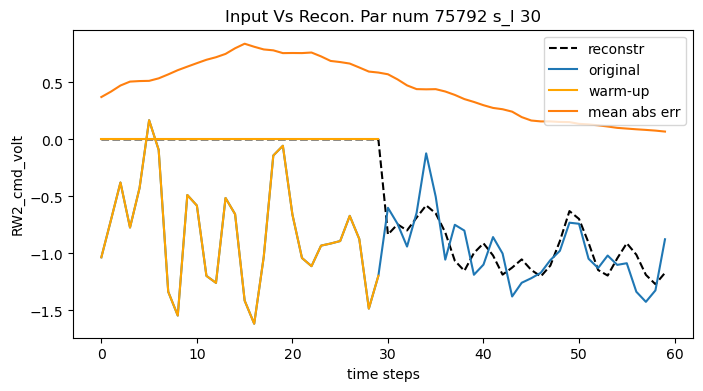

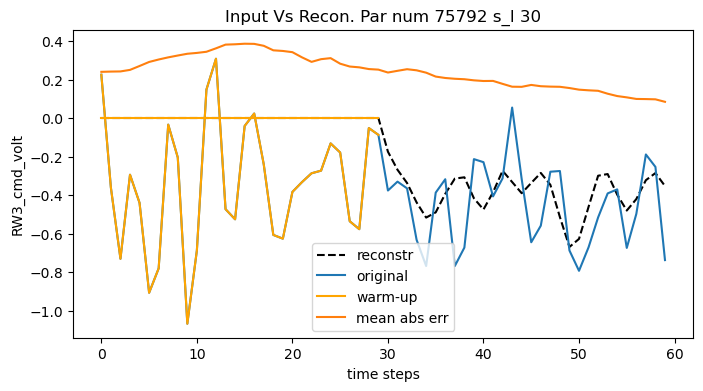

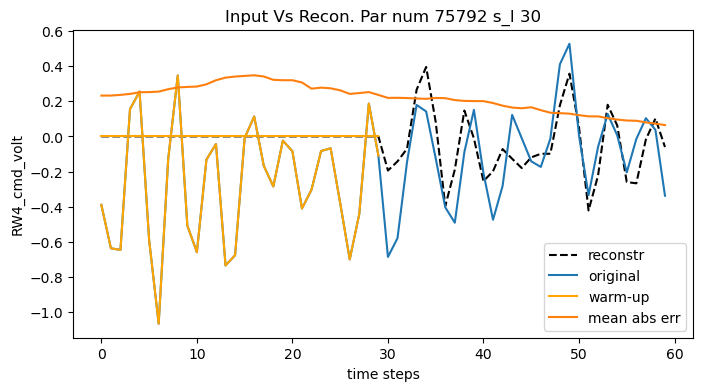

In [14]:
show_results(x.to(device),yo,cfg.dataset.columns,
    model_name,params_conf,par_nums,shift,
    num_batch,architecture='lstm',
    save=False)